In [176]:
# imports and setup
%load_ext autoreload
%autoreload 2
%cd '/home/naodell/work/hgcal/analysis'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/naodell/work/hgcal/analysis


In [198]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from sklearn import preprocessing
import seaborn as sns
from tqdm.notebook import tqdm, trange

from models.autoencoder import AutoEncoderModular
from models.loss import mse_loss_regularized
from datasets.hgcal_tc_dataset import HGCalTCModuleDictDataset

#%connect_info

In [199]:
# get the data
input_dir = 'local_data/econ_training_data/single_photon_data/'
input_filenames = [f'{input_dir}/{f}' for f in os.listdir(input_dir)]
hgcal_data = HGCalTCModuleDictDataset(input_filenames)

# sample from dataframe according to event weights; split into testing and training sets
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# training sample
batch_size = 8
n_total = len(hgcal_data)
split = round(0.8*n_total)
train_loader = DataLoader(hgcal_data[:split],  batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(hgcal_data[split:],  batch_size=batch_size, shuffle=True, pin_memory=True)
print(f'Total number of events: {n_total}')

Total number of events: 533


In [200]:
# define and setup the NN model
scenario = 'modular'
model = AutoEncoderModular().to(device)
print(device, model, sep='\n')

cuda
AutoEncoderModular(
  (encoder): ModuleDict(
    (0): WaferEncoder(
      (conv2d): Conv2d(14, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=14, bias=False)
      (act_conv): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dense_layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=128, out_features=8, bias=True)
          (1): ReLU()
        )
        (1): Sequential(
          (0): Linear(in_features=128, out_features=8, bias=True)
          (1): ReLU()
        )
        (2): Sequential(
          (0): Linear(in_features=128, out_features=8, bias=True)
          (1): ReLU()
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=8, bias=True)
          (1): ReLU()
        )
        (4): Sequential(
          (0): Linear(in_features=128, out_features=8, bias=True)
          (1): ReLU()
        )
        (5): Sequential(
          (0): Linear(in_features

In [201]:
# optimize NN weights
n_epochs = 20
n_events = len(train_loader)

# define loss and configure optimizer
loss_fn = nn.HuberLoss(reduction='sum')
#loss_fn = mse_loss_regularized

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
tb_writer = SummaryWriter(log_dir='logs')

pbar1 = tqdm(range(n_epochs), total=n_epochs, leave=False, position=0)
pbar1.set_postfix({'avg. loss':'?'})
loss_cache = []
for iepoch in pbar1:
    model.train()
    pbar2 = tqdm(train_loader, total=n_events, leave=False, position=1)
    pbar2.set_postfix({'loss':'?'})
    avg_loss = 0
    for jevent, (features, module_key) in enumerate(pbar2):
        #features = features.unsqueeze(1).to(device)
        features = features.to(device)
        #targets = targets.to(device)
        optimizer.zero_grad()
        features_pred = model(features, module_key)
        loss = loss_fn(torch.log(1. + features_pred), torch.log(1. + features))
        loss.backward()
        optimizer.step()
        
        #pbar2.set_postfix({'loss':f'{loss.item():.3f}'})
        #tb_writer.add_scalar('training loss', loss.item(), iepoch*n_events + jevent)
        
        avg_loss += loss.item()
        if jevent%1000 == 0:
            avg_loss /= 1000
            pbar2.set_postfix({'loss':f'{loss.item():.3f}'})
            #tb_writer.add_scalar('training loss', avg_loss, iepoch*(n_events//1000) + jevent/1000)
            tb_writer.add_scalar('training loss', loss.item(), iepoch*(n_events//1000) + jevent/1000)
            avg_loss = 0
        
    with torch.no_grad():
        model.eval()
        test_loss = 0
        n_test_events = len(test_loader)
        for features, module_keys in tqdm(test_loader, total=n_test_events, leave=False):
            features = features.to(device)
            #targets = targets.to(device)
            features_pred = model(features, module_keys)
            #tqdm.write(features_pred.shape, features.shape)
            test_loss += loss_fn(torch.log(1. + features_pred), torch.log(1. + features))
            loss_cache.append(test_loss.item())
            
            
        avg_loss = test_loss.item()/n_test_events
        pbar1.set_postfix({'avg loss':f'{avg_loss:.3f}'})
        tb_writer.add_scalar('test loss', avg_loss, iepoch)
        #tb_writer.add_graph(model, features)
        
        #images = torchvision.utils.make_grid(features)
        #images_pred = torchvision.utils.make_grid(features_pred)
        #tb_writer.add_image('input', images)
        #tb_writer.add_image('output', images_pred)
        
        # write a checkpoint based on the performance of the model



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'unsqueeze'

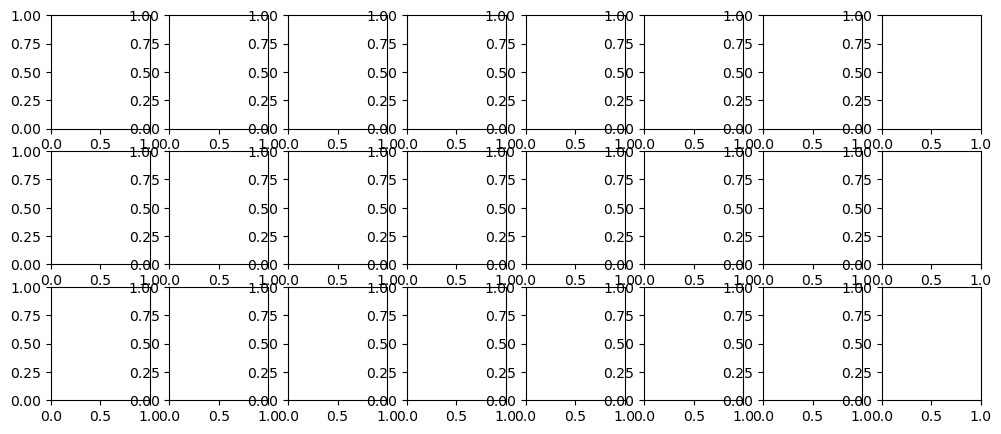

In [202]:
# compare images
from matplotlib.colors import LogNorm

with torch.no_grad():
    model.eval()
    
    fig, axes = plt.subplots(3, 8, facecolor='white', figsize=(12, 5), sharey=False, sharex=False)
    images = iter(test_loader).next()
    images = images.unsqueeze(1).to(device)
    images_pred = model(images, '(1, 1)')
    #encoded_images = model.encoder_dict['1 1'](images)
    encoded_images = model.encode(images, '(1, 1)')
    for ix, (image, encoded_image, image_pred) in enumerate(zip(images, encoded_images, images_pred)):
        image = image.squeeze().cpu().numpy()
        encoded_image = encoded_image.squeeze().cpu().numpy()
        image_pred = image_pred.squeeze().cpu().numpy().reshape(image.shape)
        energy_corr = image.sum()/image_pred.sum()
        image_pred *= energy_corr
        
        ax = axes[0][ix]
        ax.imshow(image, norm=LogNorm(vmin=0.1, vmax=100))
        ax.set_xticks([])
        ax.set_yticks([])
        if ix == 0:
            ax.set_ylabel('input')
        
        ax = axes[1][ix]
        ax.imshow(encoded_image.reshape(-1, 2), norm=LogNorm(vmin=0.1, vmax=100))
        ax.set_xticks([])
        ax.set_yticks([])
        if ix == 0:
            ax.set_ylabel('encoded')
            
        ax = axes[2][ix]
        ax.imshow(image_pred*energy_corr, norm=LogNorm(vmin=0.1, vmax=100))
        ax.set_xticks([])
        ax.set_yticks([])
        if ix == 0:
            ax.set_ylabel('output')
        
        #ax = axes[3][ix]
        #image[image ==  0] = 0.1
        #ax.imshow(abs(image - image_pred)/image, cmap='coolwarm')
        #ax.set_xticks([])
        #ax.set_yticks([])
        #if ix == 0:
        #    ax.set_ylabel('input - output')
            
        #plt.colorbar()
        
        if ix == 9: break

    plt.tight_layout()
    plt.savefig(f'plots/ae_encoding_comparisons_modular_{scenario}.png')
    plt.show()

In [ ]:
# Plot the the total error for both total energy and 
energy_diff = []
energy_sums = []
with torch.no_grad():
    model.eval()
    test_loss = 0
    n_test_events = len(test_loader)
    for features in tqdm(test_loader, total=n_test_events, leave=False):
        features = features.unsqueeze(1).to(device)
        #targets = targets.to(device)
        features_pred = model(features, '(1, 1)').squeeze()
        features = features.squeeze()
        e_sum = features.sum(dim=(1, 2))
        e_sum_pred = features_pred.sum(dim=(1, 2))
        #energy_sum_pred = features_pred.squeeze()
        
        diff = e_sum_pred - e_sum
        energy_diff.append(diff.cpu().numpy())
        energy_sums.append(e_sum.cpu().numpy())

energy_diff = np.hstack(energy_diff)
energy_sums = np.hstack(energy_sums)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]
frac_energy_diff = energy_diff/energy_sums
ax.hist(frac_energy_diff, bins=30, density=True)
ax.set_xlabel(r'$\frac{E_{pred} - E_{true}}{E_{true}}$')
ax.set_ylabel('Density')
ax.text(0.6, 0.8, f' mean = {frac_energy_diff.mean():.2f} \n std. err. = {frac_energy_diff.std():.2f}', transform=ax.transAxes)

ax = axes[1]
ax.hexbin(energy_sums, frac_energy_diff, gridsize=30, mincnt=1, norm=LogNorm())
ax.set_ylabel(r'$\frac{E_{pred} - E_{true}}{E_{true}}$', size=16)
ax.set_xlabel(r'$E_{true}$')


plt.tight_layout()
plt.savefig(f'plots/ae_energy_resolution_{scenario}.png')
plt.show()

In [ ]:
# Scan over decoder

with torch.no_grad():
    model.eval()
    
    fig, axes = plt.subplots(8, 10, facecolor='white', figsize=(12, 5), sharey=False, sharex=False)
    for i in range(8):
        test_values = np.linspace(-10, 10, 10)
        test_values = 
        images = images.unsqueeze(1).to(device)
        images_pred = model.decode(images)
            image = image.squeeze().cpu().numpy()
            encoded_image = encoded_image.squeeze().cpu().numpy()
            image_pred = image_pred.squeeze().cpu().numpy().reshape(image.shape)
            energy_corr = image.sum()/image_pred.sum()
            image_pred *= energy_corr

            ax = axes[0][ix]
            ax.imshow(image, norm=LogNorm(vmin=0.1, vmax=100))
            ax.set_xticks([])
            ax.set_yticks([])
            if ix == 0:
                ax.set_ylabel('input')

            ax = axes[1][ix]
            ax.imshow(encoded_image.reshape(-1, 2), norm=LogNorm(vmin=0.1, vmax=100))
            ax.set_xticks([])
            ax.set_yticks([])
            if ix == 0:
                ax.set_ylabel('encoded')

            ax = axes[2][ix]
            ax.imshow(image_pred*energy_corr, norm=LogNorm(vmin=0.1, vmax=100))
            ax.set_xticks([])
            ax.set_yticks([])
            if ix == 0:
                ax.set_ylabel('output')

            #ax = axes[3][ix]
            #image[image ==  0] = 0.1
            #ax.imshow(abs(image - image_pred)/image, cmap='coolwarm')
            #ax.set_xticks([])
            #ax.set_yticks([])
            #if ix == 0:
            #    ax.set_ylabel('input - output')

            #plt.colorbar()

            if ix == 9: break

    plt.tight_layout()
    plt.savefig(f'plots/ae_encoding_comparisons_modular_{scenario}.png')
    plt.show()